# Attention-based GRN Inference on Fine-tuned Model
Here we use the fine-tuned blood model on the Adamson perturbation dataset as an example of the cell-state specific GRN inference via attention weights. scGPT outputs attention weights on the individual cell level, which can be further aggregated by cell states. In this particular example, we compare the most influenced genes between a transcription factor repression condition (perturbed) and the control. However, this attention-based GRN inference is not restricted to perturbation-based discoveries. It can also be used to compare between cell states in general, such as healthy v.s. diseased, undifferentiated v.s. differentiated, as a broader application.

Users may perform scGPT's attention-based GRN inference in the following steps:

     1. Load fine-tuned scGPT model and data
     
     2. Retrieve scGPT's attention weights by condition (i.e., cell states)
     
     3. Perform scGPT's rank-based most influenced gene selection
     
     4. Validate the most influenced gene list against existing databases

NOTE in advance: to run this tutorial notebook, you may need to download the fine-tuned model from [link](https://drive.google.com/drive/folders/1HsPrwYGPXm867_u_Ye0W4Ch8AFSneXAn) and the list of targets of BHLHE40 from CHIP-Atlas for evaluation from [link](https://drive.google.com/drive/folders/1nc1LywRHlzt4Z17McfXiqBWgoGbRNyc0).

In [1]:
import copy
import json
import os
from pathlib import Path
import sys
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import tqdm
import gseapy as gp
from gears import PertData, GEARS

from scipy.sparse import issparse
import scipy as sp
from einops import rearrange
from torch.nn.functional import softmax
from tqdm import tqdm
import pandas as pd

from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.insert(0, "../")

import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.model import TransformerModel
from scgpt.utils import set_seed 
from scgpt.tokenizer import tokenize_and_pad_batch
from scgpt.preprocess import Preprocessor

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

Global seed set to 0
/h/chloexq/.cache/pypoetry/virtualenvs/scgpt--qSLVbd1-py3.9/lib/python3.9/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [2]:
set_seed(42)
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_hvg = 1200
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins

## Step 1: Load fine-tuned model and dataset

### 1.1  Load fine-tuned model

We are going to load a fine-tuned model for the gene interaction analysis on Adamson dataset. The fine-tuned model can be downloaded via this [link](https://drive.google.com/drive/folders/1HsPrwYGPXm867_u_Ye0W4Ch8AFSneXAn). The dataset will be loaded in the next step 1.2.

To reproduce the provided fine-tuned model. Please followw the integration fin-tuning pipeline to fine-tune the pre-trained blood model on the Adamson perturbation dataset. Note that in the fine-tuning stage, we did not perform highly vairable gene selection but trained on the 5000+ genes present in the Adamson dataset. This is to provide flexbility in the inference stage to investigate changes in attention maps across different perturbation conditions. 

In [3]:
# Specify model path; here we load the scGPT blood model fine-tuned on adamson
model_dir = Path("../save/finetuned_scGPT_adamson")
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = model_dir / "vocab.json"

vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

# Retrieve model parameters from config files
with open(model_config_file, "r") as f:
    model_configs = json.load(f)
print(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

gene2idx = vocab.get_stoi()

Resume model from ../save/finetuned_scGPT_adamson/best_model.pt, the model args will override the config ../save/finetuned_scGPT_adamson/args.json.


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
    use_fast_transformer=True,
)

try:
    model.load_state_dict(torch.load(model_file))
    print(f"Loading all model params from {model_file}")
except:
    # only load params that are in the model and match the size
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)

Using simple batchnorm instead of domain specific batchnorm
Loading params encoder.embedding.weight with shape torch.Size([36574, 512])
Loading params encoder.enc_norm.weight with shape torch.Size([512])
Loading params encoder.enc_norm.bias with shape torch.Size([512])
Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([512])
Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
Loading params value_encoder.linear2.bias with shape torch.Size([512])
Loading params value_encoder.norm.weight with shape torch.Size([512])
Loading params value_encoder.norm.bias with shape torch.Size([512])
Loading params bn.weight with shape torch.Size([512])
Loading params bn.bias with shape torch.Size([512])
Loading params bn.running_mean with shape torch.Size([512])
Loading params bn.running_var with shape torch.Size([512])
Loading params bn.num_batches_tracked with shape torch.Size([])
Loading

Loading params transformer_encoder.layers.6.norm1.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.6.norm2.weight with shape torch.Size([512])
Loading params transformer_encoder.layers.6.norm2.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.7.self_attn.Wqkv.weight with shape torch.Size([1536, 512])
Loading params transformer_encoder.layers.7.self_attn.Wqkv.bias with shape torch.Size([1536])
Loading params transformer_encoder.layers.7.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.7.self_attn.out_proj.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.7.linear1.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.7.linear1.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.7.linear2.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.7.linear2.bias with shape torch.Size

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(36574, 512, padding_idx=36571)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (bn): BatchNorm1d(512, eps=6.1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): FlashTransformerEncoderLayer(
        (self_attn): FlashMHA(
          (Wqkv): Linear(in_features=512, out_features=1536, bias=True)
          (inner_attn): FlashAttention()
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
   

### 1.2  Load dataset of interest
The Adamson perturbation dataset is retrieved from the GEARS package with the following code.

In [5]:
data_dir = Path("../data")
pert_data = PertData(data_dir)
pert_data.load(data_name="adamson")
adata = sc.read(data_dir / "adamson/perturb_processed.h5ad")
ori_batch_col = "control"
adata.obs["celltype"] = adata.obs["condition"].astype("category")
adata.obs["str_batch"] = adata.obs["control"].astype(str)
data_is_raw = False

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!


In [6]:
adata.var["id_in_vocab"] = [1 if gene in vocab else -1 for gene in adata.var["gene_name"]]
gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
adata = adata[:, adata.var["id_in_vocab"] >= 0]

In the scGPT workflow, we compare each TF perturbation condition with control one at a time. In each run, the data is subsetted to contain one TF and control only. In this example, we use the TF BHLHE40.

In [7]:
TF_name = 'BHLHE40'
adata = adata[adata.obs.condition.isin(['{}+ctrl'.format(TF_name), 'ctrl'])].copy()
np.unique(adata.obs.condition)

array(['BHLHE40+ctrl', 'ctrl'], dtype=object)

We further pre-process the subsetted data following the scGPT pipeline.

In [8]:
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg= False,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key="str_batch")

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Filtering cells by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Binning data ...


In [9]:
sc.pp.highly_variable_genes(
    adata,
    layer=None,
    n_top_genes=1200,
    batch_key="str_batch",
    flavor="seurat_v3" if data_is_raw else "cell_ranger",
    subset=False,
)
adata.var.loc[adata.var[adata.var.gene_name==TF_name].index, 'highly_variable'] = True
adata = adata[:, adata.var["highly_variable"]].copy()
print(adata)

AnnData object with n_obs × n_vars = 24767 × 1200
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'celltype', 'str_batch', 'n_counts'
    var: 'gene_name', 'id_in_vocab', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20', 'hvg'
    obsm: 'bin_edges'
    layers: 'X_normed', 'X_binned'


## Step 2: Retrieve scGPT's attention weights

### 2.1 Prepare model input

In [ ]:
input_layer_key = "X_binned"
all_counts = (
    adata.layers[input_layer_key].toarray()
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)
genes = adata.var["gene_name"].tolist()
gene_ids = np.array(vocab(genes), dtype=int)

In [11]:
batch_size = 16
tokenized_all = tokenize_and_pad_batch(
    all_counts,
    gene_ids,
    max_len=len(genes)+1,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=True,
)

In [12]:
all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])
condition_ids = np.array(adata.obs["condition"].tolist())

### 2.1 Retrieve attention weights
Note that since the flash-attn package does not output attention scores, we manually calculate q @ k.T to extract the attention weights. Users may specify which layer to extract the attention weights from. In the manuscript, we used the attention weights from the last (12th) layer.

In [13]:
torch.cuda.empty_cache()
dict_sum_condition = {}

In [14]:
# Use this argument to specify which layer to extract the attention weights from
# Default to 11, extraction from the last (12th) layer. Note that index starts from 0
num_attn_layers = 11 

In [15]:
model.eval()
with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):
    M = all_gene_ids.size(1)
    N = all_gene_ids.size(0)
    device = next(model.parameters()).device
    for i in tqdm(range(0, N, batch_size)):
        batch_size = all_gene_ids[i : i + batch_size].size(0)
        outputs = np.zeros((batch_size, M, M), dtype=np.float32)
        # Replicate the operations in model forward pass
        src_embs = model.encoder(torch.tensor(all_gene_ids[i : i + batch_size], dtype=torch.long).to(device))
        val_embs = model.value_encoder(torch.tensor(all_values[i : i + batch_size], dtype=torch.float).to(device))
        total_embs = src_embs + val_embs
        total_embs = model.bn(total_embs.permute(0, 2, 1)).permute(0, 2, 1)
        # Send total_embs to attention layers for attention operations
        # Retrieve the output from second to last layer
        for layer in model.transformer_encoder.layers[:num_attn_layers]:
            total_embs = layer(total_embs, src_key_padding_mask=src_key_padding_mask[i : i + batch_size].to(device))
        # Send total_embs to the last layer in flash-attn
        # https://github.com/HazyResearch/flash-attention/blob/1b18f1b7a133c20904c096b8b222a0916e1b3d37/flash_attn/flash_attention.py#L90
        qkv = model.transformer_encoder.layers[num_attn_layers].self_attn.Wqkv(total_embs)
        # Retrieve q, k, and v from flast-attn wrapper
        qkv = rearrange(qkv, 'b s (three h d) -> b s three h d', three=3, h=8)
        q = qkv[:, :, 0, :, :]
        k = qkv[:, :, 1, :, :]
        v = qkv[:, :, 2, :, :]
        # https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a
        # q = [batch, gene, n_heads, n_hid]
        # k = [batch, gene, n_heads, n_hid]
        # attn_scores = [batch, n_heads, gene, gene]
        attn_scores = q.permute(0, 2, 1, 3) @ k.permute(0, 2, 3, 1)
        # Rank normalization by row
        attn_scores = attn_scores.reshape((-1, M))
        order = torch.argsort(attn_scores, dim=1)
        rank = torch.argsort(order, dim=1)
        attn_scores = rank.reshape((-1, 8, M, M))/M
        # Rank normalization by column
        attn_scores = attn_scores.permute(0, 1, 3, 2).reshape((-1, M))
        order = torch.argsort(attn_scores, dim=1)
        rank = torch.argsort(order, dim=1)
        attn_scores = (rank.reshape((-1, 8, M, M))/M).permute(0, 1, 3, 2)
        # Average 8 attention heads
        attn_scores = attn_scores.mean(1)
        
        outputs = attn_scores.detach().cpu().numpy()
        
        for index in range(batch_size):
            # Keep track of sum per condition
            c = condition_ids[i : i + batch_size][index]
            if c not in dict_sum_condition:
                dict_sum_condition[c] = np.zeros((M, M), dtype=np.float32)
            else:
                dict_sum_condition[c] += outputs[index, :, :]

100%|██████████| 1548/1548 [08:56<00:00,  2.88it/s]


### 2.2 Average rank-normed attention weights by condition
In the previous step, we retrieve the attention weights for all cells and keep the running sum by condition (i.e., control, perturbed). We further calculate the mean here by dividing the number of cells per condition to obtain a gene * gene attention matrix for each condition.

In [16]:
groups = adata.obs.groupby('condition').groups

In [17]:
dict_sum_condition_mean = dict_sum_condition.copy()
for i in groups.keys():
    dict_sum_condition_mean[i] = dict_sum_condition_mean[i]/len(groups[i])
gene_vocab_idx = all_gene_ids[0].clone().detach().cpu().numpy()

In [18]:
dict_sum_condition_mean

{'ctrl': array([[0.7667165 , 0.5071312 , 0.363181  , ..., 0.6558552 , 0.6433118 ,
         0.5029277 ],
        [0.35063276, 0.90670127, 0.32875505, ..., 0.67563516, 0.4646933 ,
         0.4744476 ],
        [0.5349599 , 0.30492574, 0.63999563, ..., 0.37222496, 0.45482123,
         0.4780819 ],
        ...,
        [0.5522125 , 0.72981244, 0.347227  , ..., 0.7278823 , 0.5751889 ,
         0.48467204],
        [0.5728605 , 0.54362035, 0.49283794, ..., 0.5536558 , 0.71726304,
         0.59353757],
        [0.646479  , 0.52209556, 0.410678  , ..., 0.5902157 , 0.6444179 ,
         0.54989314]], dtype=float32),
 'BHLHE40+ctrl': array([[0.6798215 , 0.43131036, 0.39218244, ..., 0.67530143, 0.6967861 ,
         0.5009627 ],
        [0.28934428, 0.809951  , 0.30970335, ..., 0.61639196, 0.26737106,
         0.2312922 ],
        [0.5355754 , 0.28648922, 0.6779555 , ..., 0.3633715 , 0.51926744,
         0.59302956],
        ...,
        [0.5082808 , 0.69850725, 0.34680215, ..., 0.75059116, 0.61094

## Step 3: Perform most influenced gene selection

In the manuscript, we proposed 3 settings for the most influenced gene selection, namely *Control*, *Perturb*, and *Difference*. In this example, we focus on the *Difference* setting to explore how the gene-gene network changes after perturbation compared to control.

In [19]:
def get_topk_most_influenced_genes(topk, setting):
    attn_top_gene_dict = {}
    attn_top_scores_dict = {}
    for i in groups.keys():
        if i != 'ctrl':
            knockout_gene = i.split('+')[0]
            knockout_gene_idx = np.where(gene_vocab_idx==vocab([knockout_gene])[0])[0][0]
            control = dict_sum_condition_mean['ctrl'][:, knockout_gene_idx]
            exp = dict_sum_condition_mean[i][:, knockout_gene_idx]
            # Chnage this line to exp, control, exp-control for three different settings
            if setting == 'difference':
                a = exp-control
            elif setting == 'control':
                a = control
            elif setting == 'experiment':
                a = exp
            diff_idx = np.argpartition(a, -topk)[-topk:]
            scores = (a)[diff_idx]
            attn_top_genes = vocab.lookup_tokens(gene_vocab_idx[diff_idx]) + [TF_name]
            attn_top_gene_dict[i] = list(attn_top_genes)
            attn_top_scores_dict[i] = list(scores)
    return attn_top_gene_dict, attn_top_scores_dict

In [20]:
gene_vocab_idx = all_gene_ids[0].clone().detach().cpu().numpy()

In [21]:
# Specify top k number of genes to be selected, and the selection setting
# Here calculate top 20 most influenced genes for CHIP-Atlas validation
topk = 20
setting = 'difference' # "control", "perturbed"
assert setting in ["difference", "control", "perturbed"]
attn_top_gene_dict_20, attn_top_scores_dict_20 = get_topk_most_influenced_genes(topk, setting)
print(attn_top_scores_dict_20[TF_name + '+ctrl'])
print(attn_top_gene_dict_20[TF_name + '+ctrl'])

[0.27003407, 0.27020293, 0.27515042, 0.28356528, 0.2868172, 0.2719887, 0.27392942, 0.28411555, 0.27914363, 0.27320516, 0.27022785, 0.2799158, 0.27595383, 0.27598792, 0.27211004, 0.28957933, 0.29275084, 0.2942825, 0.30242187, 0.29776084]
['SH3BGRL3', 'HBA1', 'PSMD4', 'FKBP2', 'HSPA8', 'HNRNPD', 'NDUFB6', 'RTN4', 'DNAJA1', 'SSR2', 'NENF', 'UQCRB', 'HSP90B1', 'PRRC2C', 'ADRM1', 'DBI', 'HSPB1', 'HMGN3', 'TMBIM6', 'ACAT2', 'BHLHE40']


<Figure size 1800x1800 with 0 Axes>

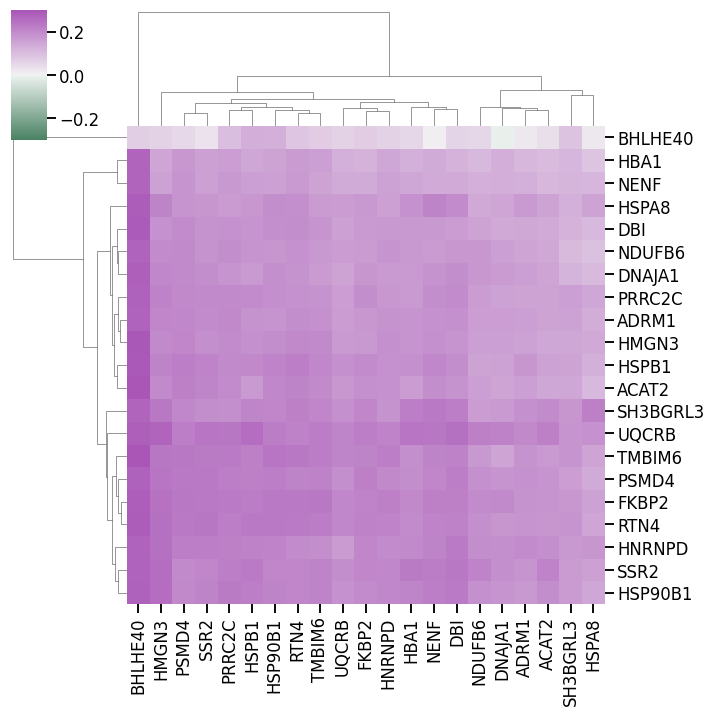

In [23]:
if setting == 'difference':
    for i in attn_top_gene_dict_20.keys():
        example_genes = attn_top_gene_dict_20[i]
        gene_idx = [np.where(gene_vocab_idx==vocab([g])[0])[0][0] for g in example_genes]
        scores = dict_sum_condition_mean[i][gene_idx, :][:, gene_idx]-dict_sum_condition_mean['ctrl'][gene_idx, :][:, gene_idx]
        df_scores = pd.DataFrame(data = scores, columns = example_genes, index = example_genes)
        plt.figure(figsize=(6, 6), dpi=300)
        ax = sns.clustermap(df_scores, annot=False, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True), fmt='.2f', vmin=-0.3, vmax=0.3) 
        plt.show()
        plt.close()

In [24]:
# Specify top k number of genes to be selected, and the selection setting
# # Here calculate top 100 most influenced genes for pathway validation
topk = 100
setting = 'difference' # "control", "perturbed"
assert setting in ["difference", "control", "perturbed"]
attn_top_gene_dict_100, attn_top_scores_dict_100 = get_topk_most_influenced_genes(topk, setting)
print(attn_top_scores_dict_100[TF_name + '+ctrl'])
print(attn_top_gene_dict_100[TF_name + '+ctrl'])

[0.13435426, 0.13445804, 0.13521338, 0.13658851, 0.13494265, 0.1378941, 0.25253183, 0.27598792, 0.27320516, 0.19422996, 0.1749267, 0.14947963, 0.28356528, 0.19787788, 0.21807176, 0.27211004, 0.19592029, 0.192339, 0.26201934, 0.27022785, 0.18904561, 0.2630661, 0.17665666, 0.25517708, 0.1592493, 0.28411555, 0.15643954, 0.17658818, 0.28957933, 0.23216242, 0.27515042, 0.17963398, 0.17776287, 0.21403193, 0.1494323, 0.26097095, 0.2147252, 0.2868172, 0.1864397, 0.19282275, 0.17112768, 0.18815774, 0.19837373, 0.14006501, 0.15750575, 0.22382861, 0.2719887, 0.25040454, 0.25988054, 0.26159328, 0.14806324, 0.20562506, 0.26052994, 0.20960271, 0.17409635, 0.22525501, 0.26490605, 0.20550716, 0.15476418, 0.14542323, 0.30242187, 0.16769892, 0.1891504, 0.16443193, 0.2682315, 0.25884175, 0.25024498, 0.26073533, 0.15007758, 0.27020293, 0.27914363, 0.24032599, 0.16723317, 0.18915558, 0.27392942, 0.15589827, 0.1956358, 0.15076661, 0.14257717, 0.2255286, 0.18222451, 0.2942825, 0.18665028, 0.29776084, 0.29275

## Step 4: Validate most influenced genes

### Step 4.1: Validate against CHIP-Atlas

First load the tsv file from CHIP-Atlas containing targets of BHLHE40. The tsv file for BHLHE40 can be downloaded via this [link](https://drive.google.com/drive/folders/1nc1LywRHlzt4Z17McfXiqBWgoGbRNyc0). This tsv file was originally retrieved from the [CHIP-Atlas](https://chip-atlas.org/target_genes) website.

In [25]:
df = pd.read_csv('./reference/BHLHE40.10.tsv', delimiter='\t')

Examine the overalp between the selected genes (top 20) and known target genes from the database.

In [26]:
gene_list = attn_top_gene_dict_20[TF_name + '+ctrl'][:-1]
set(gene_list).intersection(set(df['Target_genes'].values)), len(set(gene_list).intersection(set(df['Target_genes'].values)))

({'ACAT2',
  'ADRM1',
  'DBI',
  'DNAJA1',
  'FKBP2',
  'HBA1',
  'HMGN3',
  'HNRNPD',
  'HSP90B1',
  'HSPA8',
  'HSPB1',
  'NDUFB6',
  'PRRC2C',
  'PSMD4',
  'RTN4',
  'SH3BGRL3',
  'SSR2',
  'TMBIM6',
  'UQCRB'},
 19)

Visualize the network and strength of the edges (annotated with rank-normalized attention scores).

In [27]:
score_list = attn_top_scores_dict_20[TF_name + '+ctrl']

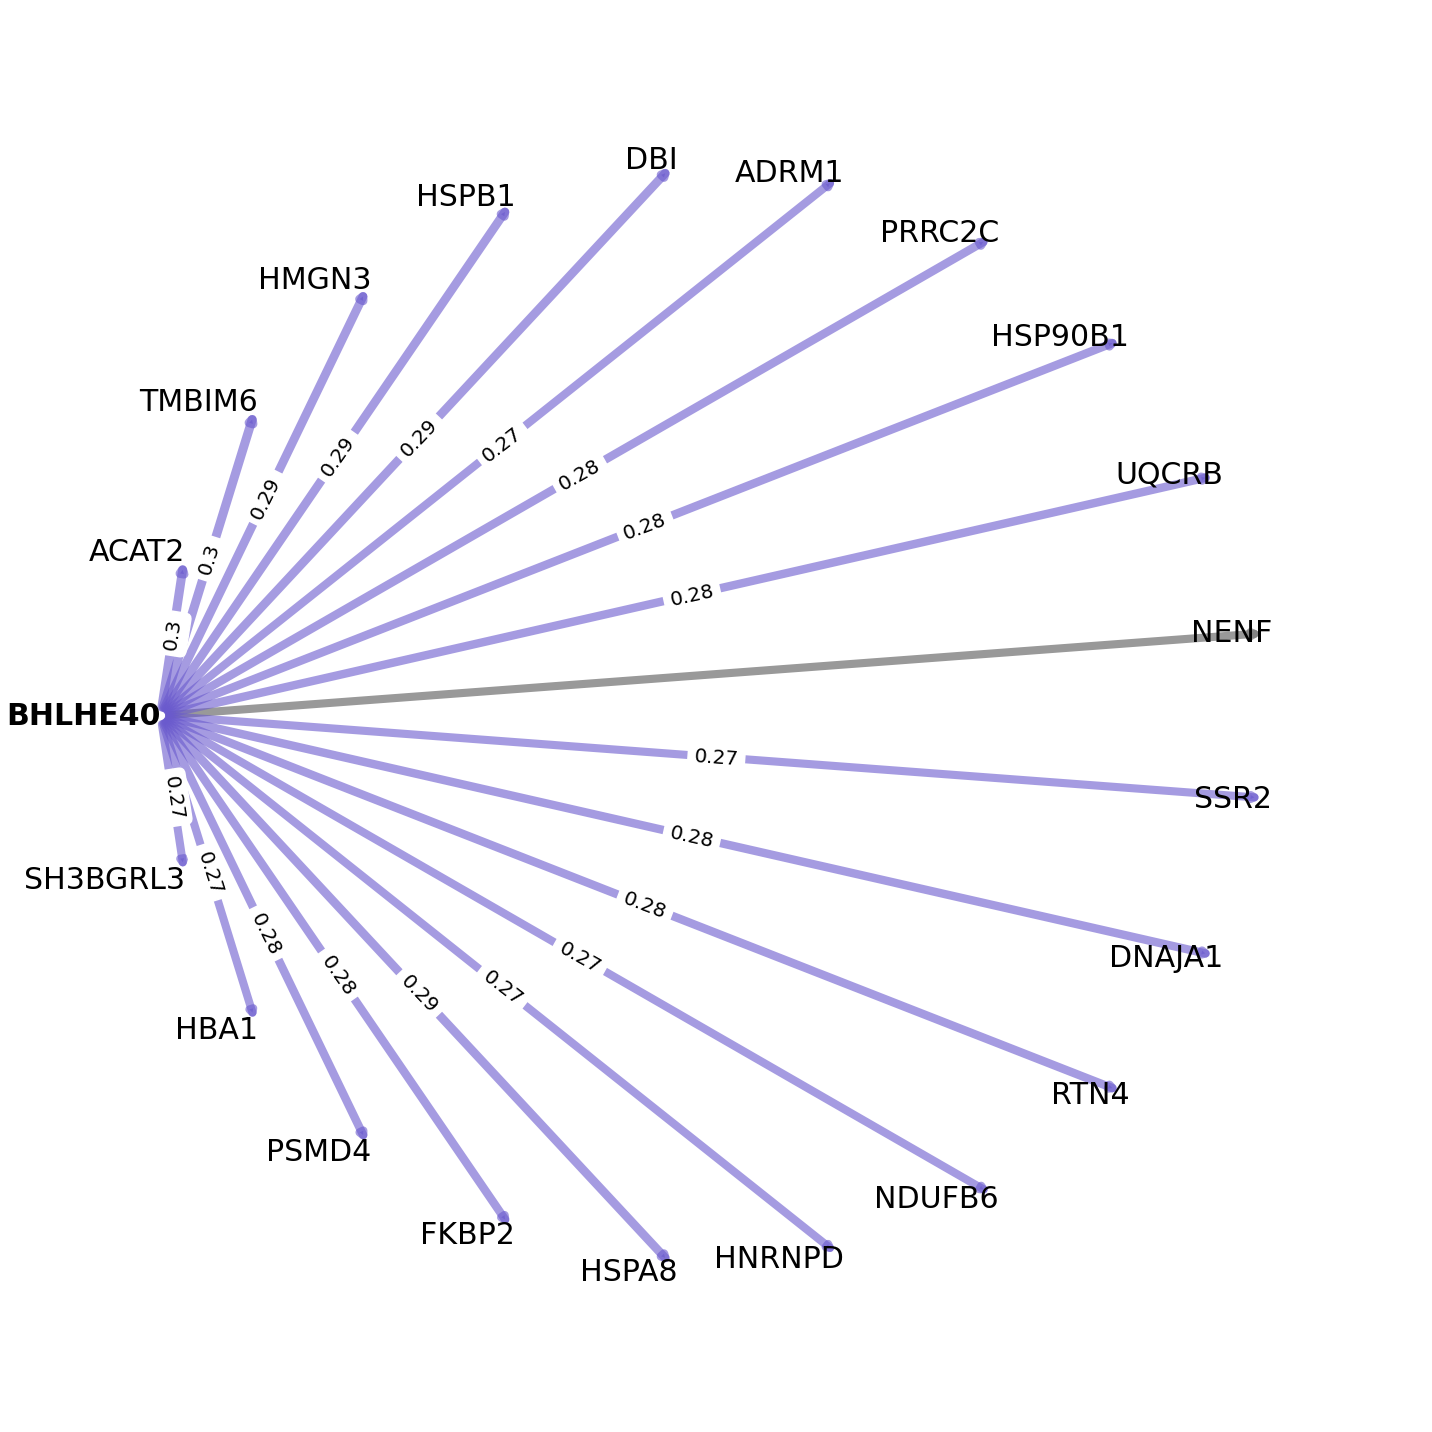

In [28]:
hits = set(gene_list).intersection(set(df['Target_genes'].values))

G = nx.DiGraph()
edge_list = [(TF_name, gene_list[i], round(score_list[i], 2)) for i in range(len(gene_list))]
G.add_weighted_edges_from(edge_list)

plt.figure(figsize=(20, 20))
edges = list(G.edges)
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if v in hits]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if v not in hits]
pos = nx.shell_layout(G)
width_large = {}
width_small = {}
for i, v in enumerate(edges):
    if v[1] in hits:
        width_large[edges[i]] = G.get_edge_data(v[0], v[1])['weight']*30
    else:
        width_small[edges[i]] = max(G.get_edge_data(v[0], v[1])['weight'], 0)*30
nx.draw_networkx_edges(G, pos,
                       edgelist = width_small.keys(),
                       width=list(width_small.values()),
                       edge_color='grey',
                       alpha=0.8)
nx.draw_networkx_edges(G, pos, 
                       edgelist = width_large.keys(), 
                       width = list(width_large.values()), 
                       alpha = 0.6, 
                       edge_color = "slateblue",
                      )
labels = {}
for i in pos.keys():
    if i == TF_name:
        labels[i] = ''
    else:
        labels[i] = i
        
labels1 = {}
for i in pos.keys():
    if i != TF_name:
        labels1[i] = ''
    else:
        labels1[i] = i
nx.draw_networkx_labels(G, pos, labels, font_size=30, font_family="sans-serif", horizontalalignment='right')
nx.draw_networkx_labels(G, pos, labels1, font_size=30, font_family="sans-serif", font_weight='bold', horizontalalignment='right')

d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in elarge}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=20)
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

### Step 4.2: Validate against the Reactome database

We perform pathway analysis on the top 100 most influenced genes by checking against the Reactome database. This replicates the reported pathways found in the *Difference* setting in the manuscript for the select TF.

In [29]:
# Validate with Reactome 
df_database = pd.DataFrame(
data = [['GO_Biological_Process_2021', 6036],
['GO_Molecular_Function_2021', 1274],
['Reactome_2022', 1818]],
columns = ['dataset', 'term'])

In [30]:
databases = ['Reactome_2022']
m = df_database[df_database['dataset'].isin(databases)]['term'].sum() #df_database['term'].sum()
p_thresh = 0.05/((len(groups.keys())-1)*m)

In [31]:
gene_list = attn_top_gene_dict_100[TF_name + '+ctrl']

In [32]:
df_attn = pd.DataFrame()
enr_Reactome = gp.enrichr(gene_list=gene_list,
                           gene_sets=databases,
                           organism='Human', 
                           outdir='test',
                           cutoff=0.5)
out = enr_Reactome.results
out['Gene List'] = str(gene_list)
out = out[out['P-value'] < p_thresh]
df_attn = df_attn.append(out, ignore_index=True)

In [33]:
len(df_attn)

6

In [34]:
df_attn

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene List
0,Reactome_2022,AUF1 (hnRNP D0) Binds And Destabilizes mRNA R-...,6/54,3.029798e-07,0.000087,0,0,26.119737,392.046796,HSPA8;PSMD12;PSMD4;UBC;HNRNPD;HSPB1,"['IL1RN', 'ARHGDIB', 'COL2A1', 'TRAPPC6A', 'PC..."
1,Reactome_2022,Regulation Of mRNA Stability By Proteins That ...,7/88,3.082629e-07,0.000087,0,0,18.219858,273.157814,HSPA8;PSMD12;PSMD4;EXOSC8;UBC;HNRNPD;HSPB1,"['IL1RN', 'ARHGDIB', 'COL2A1', 'TRAPPC6A', 'PC..."
2,Reactome_2022,Cellular Responses To Stress R-HSA-2262752,16/722,6.458517e-07,0.000117,0,0,5.117280,72.935042,HSPA8;PSMD12;HSPA5;CITED2;HBA1;HSP90B1;EEF1A1;...,"['IL1RN', 'ARHGDIB', 'COL2A1', 'TRAPPC6A', 'PC..."
3,Reactome_2022,Cellular Responses To Stimuli R-HSA-8953897,16/736,8.318572e-07,0.000117,0,0,5.014118,70.195667,HSPA8;PSMD12;HSPA5;CITED2;HBA1;HSP90B1;EEF1A1;...,"['IL1RN', 'ARHGDIB', 'COL2A1', 'TRAPPC6A', 'PC..."
4,Reactome_2022,S Phase R-HSA-69242,7/161,1.753446e-05,0.001971,0,0,9.547872,104.562021,PSMD12;PCNA;PSMD4;UBE2S;MYC;UBC;MCM3,"['IL1RN', 'ARHGDIB', 'COL2A1', 'TRAPPC6A', 'PC..."
5,Reactome_2022,APC/C:Cdc20 Mediated Degradation Of Securin R-...,5/67,2.239572e-05,0.002098,0,0,16.664147,178.417027,PSMD12;PSMD4;PTTG1;UBE2S;UBC,"['IL1RN', 'ARHGDIB', 'COL2A1', 'TRAPPC6A', 'PC..."
